# Import Library

In [1]:
# load data
import os

# computing
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# feature extraction
import cv2
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans

# modelling
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# evalutaion
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# load/save model
import pickle

### Define common pickle method

In [4]:
def load_file_pickle(filename):
    file_pickle = pickle.load(open(filename, 'rb'))
    return file_pickle

def save_file_pickle(variable, filename):
    pickle.dump(variable, open(filename, 'wb'))

#### Constant variable

In [5]:
BOW_FILE_PICKLE = "bow_dictionary.pkl"
SCALER_WS_FILE_PICKLE = "scaler_with_sift.pkl"
SCALER_WOS_FILE_PICKLE = "scaler_without_sift.pkl"
SVM_WS_FILE_PICKLE = "svm_with_sift_model.pkl"
SVM_WOS_FILE_PICKLE = "svm_without_sift_model.pkl"

# Load Data

- input: -
- output: `raw_X, raw_y`

In [6]:
# ukurang gambar 224x224
def import_image(file) :
    image = cv2.imread(file)
    image = cv2.bitwise_not(image)
    return image

def label_image(character, length) :
    array = np.full(length, character)
    return array

def import_data(character, path) :
    file_path = os.listdir(path)
    images = np.array([import_image(path + '/' + file) for file in file_path])
    label = label_image(character, len(file_path))
    
    return images, label

In [7]:
hanacaraka = ('ba','ca','da','dha','ga','ha','ja','ka','la','ma','na','nga','nya','pa','ra','sa','ta','tha','wa','ya')

raw_X = np.empty((0, 224, 224, 3), np.uint8)
raw_y = np.empty((0))

folder_path = "../Dataset/campuran/" # for local used
# folder_path = "drive/MyDrive/Skripsi/Repos/Dataset/campuran/" # for drive used

for character in hanacaraka:
    dataset_path = folder_path + character

    temp_X, temp_y = import_data(character, dataset_path)

    print("Size of", character, ":", temp_X.shape[0])
    
    raw_X = np.append(raw_X, temp_X, axis=0)
    raw_y = np.append(raw_y, temp_y, axis=0)


Size of ba : 21
Size of ca : 21
Size of da : 21
Size of dha : 21
Size of ga : 21
Size of ha : 21
Size of ja : 21
Size of ka : 21
Size of la : 21
Size of ma : 21
Size of na : 21
Size of nga : 21
Size of nya : 21
Size of pa : 21
Size of ra : 21
Size of sa : 21
Size of ta : 21
Size of tha : 21
Size of wa : 21
Size of ya : 21


In [8]:
# Ukuran keseluruhan data
print("Number of data:", raw_X.shape[0])
print("Image dimension:", raw_X[0].shape)

Number of data: 420
Image dimension: (224, 224, 3)


### Visualize Raw Data

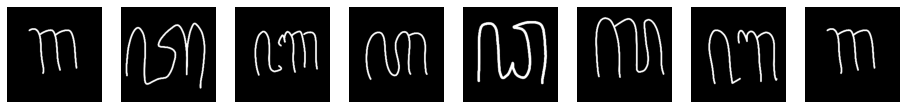

In [9]:
np.random.seed(42)

fig = plt.figure(figsize=(16, 4))
columns = 8
rows = 1
for i in range(1, columns*rows + 1):
    img = np.array(raw_X[np.random.randint(0, raw_X.shape[0]), :])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis('off')

plt.show()

# Augmantation & Preparation Data

- input: `raw_X, raw_y`
- output: `X, y`

List Augmented :
1. Rotate 30 CCW
2. Rotate 15 CCW + Zoom out
3. Rotate 15 CW + Zoom out
4. Rotate 30 CW
5. Shear Left
6. Shear Right
7. Normal

List Preprocessing :
1. Resizing (128x128)
2. Grayscaling
3. Equalization

### Augmented Method

In [10]:
# Augmented Method
def rotate(img, degree):
    (h, w) = img.shape[:2]
    (cX, cY) = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D((cX, cY), degree, 1.0)
    img_rotated = cv2.warpAffine(img, M, (w, h))
    return img_rotated

def zoom_out(img, zoom_scale):
    img_zoom = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)

    h, w = img.shape[0]/zoom_scale, img.shape[1]/zoom_scale
    h, w = int(h), int(w)
    x, y = (img.shape[0]-w)//2, (img.shape[1]-h)//2
    img_resize = cv2.resize(img, (h, w), interpolation = cv2.INTER_AREA)

    img_zoom[x:w+x, y:h+y] = img_resize
    return img_zoom

def shear(img, x, y):
    rows, cols = img.shape
    M = np.float32([[1, x, 0],
                    [y, 1, 0]])
    sheared_img = cv2.warpAffine(img, M, (cols, rows))
    return sheared_img

### Image Preprocessing Method

In [11]:
# Preprocessing Image
def equalizing(img):
    if (img.ndim == 3):
        b, g, r = cv2.split(img)
        red = cv2.equalizeHist(r)
        green = cv2.equalizeHist(g)
        blue = cv2.equalizeHist(b)
        img = cv2.merge((blue, green, red))
    else:
        img = cv2.equalizeHist(img)
    return img

def grayscaling(image):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    return image

def resizing(image, size):
    image = cv2.resize(image, (size, size), interpolation = cv2.INTER_AREA)
    return image

In [12]:
# Generate augmentation and preprocessing data
def dataset_aug_generator_prep(ori_img):
    ori_img = resizing(ori_img, 192)
    ori_img = grayscaling(ori_img)
    
    ori_img = zoom_out(ori_img, 1.15)
    img_r_30_ccw = rotate(ori_img, 30)
    img_r_30_cw = rotate(ori_img, -30)
    img_r_15_ccw_z = rotate(zoom_out(ori_img, 1.3), 15)
    img_r_15_cw_z = rotate(zoom_out(ori_img, 1.3), -15)
    img_s_left = shear(ori_img, -0.15, -0.15)
    img_s_right = shear(ori_img, 0.15, 0.15)
    
    result_aug = [ori_img, img_r_30_ccw, img_r_30_cw, img_r_15_ccw_z, img_r_15_cw_z, img_s_left, img_s_right]
    for idx, item_img in enumerate(result_aug):
        result_aug[idx] = equalizing(result_aug[idx])
    return result_aug

#### test result image after generate augmentation and preprocessing

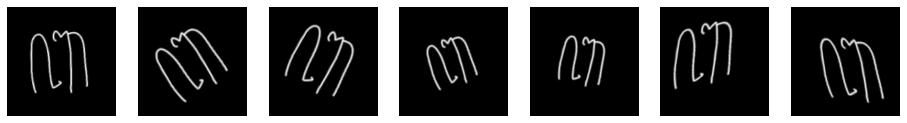

In [13]:
test_img_aug = dataset_aug_generator_prep(raw_X[0])

fig = plt.figure(figsize=(16, 4))
columns = 7
rows = 1
for i in range(1, columns*rows + 1):
    img = test_img_aug[i-1]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap='gray', vmin=0, vmax=255)
    plt.axis('off')

plt.show()

## Generate Aug & Prep Image on All Raw Data

In [16]:
X = np.empty((0, 192, 192), np.uint8)
y = np.empty((0))

for idx, img in enumerate(raw_X):
    img_aug = dataset_aug_generator_prep(img)
    
    for item_img in img_aug:
        X = np.append(X, [item_img], axis=0)
        y = np.append(y, [raw_y[idx]], axis=0)

In [17]:
print("Result X data dimension:", X.shape)
print("Result y data dimension:", y.shape)

Result X data dimension: (2940, 192, 192)
Result y data dimension: (2940,)


### Visualize Result Data

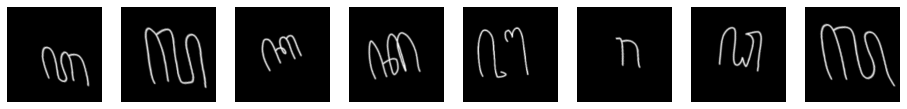

In [18]:
np.random.seed(42)

fig = plt.figure(figsize=(16, 4))
columns = 8
rows = 1
for i in range(1, columns*rows + 1):
    img = np.array(X[np.random.randint(0, X.shape[0]), :])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap='gray', vmin=0, vmax=255)
    plt.axis('off')

plt.show()

# Feature Extraction

- input: `X`
- output: `X_feature`

### Extract SIFT Descriptors 

In [19]:
def extract_sift_features(list_image):

    image_descriptors = []
    sift = cv2.SIFT_create()
    for image in list_image:
        _, descriptor = sift.detectAndCompute(image, None)
        image_descriptors.append(descriptor)

    return image_descriptors

def split_all_descriptors(image_descriptors):
    all_descriptors = []
    for descriptor in image_descriptors:
        if descriptor is not None:
            for des in descriptor:
                all_descriptors.append(des)
    
    return np.array(all_descriptors)

In [20]:
image_descriptors = extract_sift_features(X)

In [21]:
all_descriptors = split_all_descriptors(image_descriptors)
print("Number of keypoint descriptor:", all_descriptors.shape)

Number of keypoint descriptor: (193416, 128)


### Create BOW of Descriptor Using Cluster

In [22]:
def kmeans_bow(all_descriptors, num_cluster):
    if not os.path.isfile(BOW_FILE_PICKLE):
        kmeans = KMeans(n_clusters = num_cluster, verbose=1)
        kmeans.fit(all_descriptors)

        bow_dict = kmeans.cluster_centers_
        
        save_file_pickle(BOW_FILE_PICKLE)
    else:
        bow_dict = load_file_pickle(BOW_FILE_PICKLE)

    return bow_dict

In [19]:
num_cluster = 750
bow = kmeans_bow(all_descriptors, num_cluster)

### Create Features From BOW

In [20]:
def create_feature_bow(image_descriptors, bow, num_cluster):
    X_features = []

    for i in range(len(image_descriptors)):
        features = np.array([0] * num_cluster, dtype=float)

        if image_descriptors[i] is not None:
            distance = cdist(image_descriptors[i], bow)
            argmin = np.argmin(distance, axis = 1)

            for j in argmin:
                features[j] += 1.0
        X_features.append(features)

    return np.array(X_features)

In [21]:
X_feature = create_feature_bow(image_descriptors, bow, num_cluster)

print("Feature X data dimension:", X_feature.shape)

Feature X data dimension: (2940, 500)


# Classification With SIFT

- input: `X_feature, y`
- output: -

In [22]:
# normalization
scaler = StandardScaler().fit(X_feature)
X_scale = scaler.transform(X_feature)

#### Save scaler

In [23]:
# Just save normalization function for future used
save_file_pickle(SCALER_WS_FILE_PICKLE)

In [25]:
# splitting data
X_train, X_test, y_train, y_test = train_test_split(X_scale, y, test_size=0.15, random_state=42)

print("Size of training:", X_train.shape[0])
print("Size of testing:", X_test.shape[0])

NameError: name 'X_scale' is not defined

# Test Manual SVM

In [23]:
import math

In [24]:
print(y_train[:300])

NameError: name 'y_train' is not defined

In [27]:
ans = [i for i in range(len(y_train[:300])) if y_train[:300][i] == 'ka']
ans

[11, 15, 64, 65, 70, 170, 196, 209, 246, 254, 280]

In [58]:
max_v = 0
max_i = 0
min_i = 0
min_v = 1
b = 0.3307088631348539

for i in range(300):
    if i != 2 and i != 27 and i != 119 and i!= 201:
        ans2 = rbf(sigma, X_train[2], X_train[i])
        print(ans2)
        if ans2 > max_v:
            max_i = i
            max_v = ans2
        
        if ans2 < min_v:
            min_i = i
            min_v = ans2
        

print(min_v, min_i)

0.108783880330162
0.11565447488165465
0.11820971503023836
0.15669976085377407
0.10337984337631666
0.0774873358642158
0.08486828779773667
0.1819795076274031
0.15041301693884762
0.19248433509114743
0.1414701006412527
0.2001079156304603
0.11682660617529124
0.2557360203812365
0.1357854150337872
0.07990470938794356
0.06397048393310327
0.1627788951418826
0.1476692499043197
0.11206395959436206
0.045964398285393566
0.2986632386024186
0.15080431694263957
0.18618494947890032
0.11969137979763503
0.08950987279362355
0.05868865524844969
0.1937675453316746
0.13926575144361034
0.05947653827086657
0.21497737831747576
0.20151093971488812
0.0883534429052609
0.10977368806023731
0.08907867227803574
0.09108454353170693
0.2514856849510367
0.07182178188334064
0.24335910447879158
0.08506017854618947
0.15731085217633936
0.2182371085091971
0.23040599541796564
0.09541647637480927
0.1391057465920841
0.20423546816568608
0.18250344554547945
0.22350148124800884
0.1723985911853921
0.14244390014362499
0.13766783682339

In [55]:
rbf(sigma, X_train[2], X_train[201])

0.030321300263455597

In [ ]:
idx_i

298

In [ ]:
idx_j

283

In [ ]:
rbf(sigma, X_train[298], X_train[283])

0.05142079064547177

In [54]:
y_train[201]

'ma'

In [60]:
test_X = np.array([
    X_train[2],
    X_train[27],
    X_train[119],
    X_train[201],
    X_train[284]
])

test_y = np.array([
    y_train[2],
    y_train[27],
    y_train[119],
    y_train[201],
    y_train[284]
])

test_y

array(['ba', 'ba', 'nya', 'ma', 'ma'], dtype='<U3')

In [61]:
test_y = np.array([1, 1, -1, -1, -1])
test_y

array([ 1,  1, -1, -1, -1])

In [80]:
# semua fungsi manual

sigma = 15.81
def rbf(sigma, x1, x2):
    gamma = 1/(2*(sigma**2))
    length = sum((x1 - x2) ** 2)
    print(length)
    result = math.exp(-gamma * length)
    return result


def calc_sigma(gamma):
    result = math.sqrt(1/(2*gamma))
    return result

lambdaa = 0.5
def hessian(y1, y2, k, lambdaa):
    result = y1*y2*(k+(lambdaa**2))
    return result

def error(data, alfa):
    result = sum(data * alfa)
    return result

gamma = 0.001
var_C = 1
def delta_alfa(gamma, var_C, alfa, error):
    calc_max = max([gamma*(1-error), alfa])
    calc_min = min([calc_max, var_C-alfa])
    result = calc_min
    return result

def new_alfa(old_alfa, delta_alfa):
    result = old_alfa + delta_alfa
    return result

In [63]:
calc_sigma(0.002)

15.811388300841896

In [64]:
# calc gamma
1/(2 * (15.811388300841896 ** 2))

0.002

In [65]:
Matrix_RBF = np.zeros((5,5))

for i in range(5):
    for j in range(5):
        Matrix_RBF[i][j] = rbf(sigma, test_X[i], test_X[j])

Matrix_RBF

array([[1.        , 0.33070886, 0.02627371, 0.0303213 , 0.03641921],
       [0.33070886, 1.        , 0.02452981, 0.03978491, 0.04552518],
       [0.02627371, 0.02452981, 1.        , 0.00481004, 0.00508454],
       [0.0303213 , 0.03978491, 0.00481004, 1.        , 0.0541797 ],
       [0.03641921, 0.04552518, 0.00508454, 0.0541797 , 1.        ]])

In [66]:
Hessian = np.zeros((5,5))

for i in range(5):
    for j in range(5):
        Hessian[i][j] = hessian(test_y[i], test_y[j], Matrix_RBF[i][j], lambdaa)

Hessian

array([[ 1.25      ,  0.58070886, -0.27627371, -0.2803213 , -0.28641921],
       [ 0.58070886,  1.25      , -0.27452981, -0.28978491, -0.29552518],
       [-0.27627371, -0.27452981,  1.25      ,  0.25481004,  0.25508454],
       [-0.2803213 , -0.28978491,  0.25481004,  1.25      ,  0.3041797 ],
       [-0.28641921, -0.29552518,  0.25508454,  0.3041797 ,  1.25      ]])

In [67]:
# alfa = np.array([0.01, 0.01, 0.01, 0.01, 0.01])
alfa = np.zeros(5)
alfa

array([0., 0., 0., 0., 0.])

In [68]:
Error = np.zeros(5)

for i in range(5):
    Error[i] = error(Hessian[i], alfa[i])

Error

array([0., 0., 0., 0., 0.])

In [69]:
Delta_alfa = np.zeros(5)

for i in range(5):
    Delta_alfa[i] = delta_alfa(gamma, var_C, alfa[i], Error[i])

Delta_alfa

array([0.001, 0.001, 0.001, 0.001, 0.001])

In [70]:
for i in range(5):
    alfa[i] = new_alfa(alfa[i], Delta_alfa[i])

alfa

array([0.001, 0.001, 0.001, 0.001, 0.001])

In [71]:
iterasi = 10

for x in range(iterasi):
    Error = np.zeros(5)
    for i in range(5):
        Error[i] = error(Hessian[i], alfa[i])

    Delta_alfa = np.zeros(5)
    for i in range(5):
        Delta_alfa[i] = delta_alfa(gamma, var_C, alfa[i], Error[i])

    for i in range(5):
        alfa[i] = new_alfa(alfa[i], Delta_alfa[i])

    print(alfa)

[0.002 0.002 0.002 0.002 0.002]
[0.004 0.004 0.004 0.004 0.004]
[0.008 0.008 0.008 0.008 0.008]
[0.016 0.016 0.016 0.016 0.016]
[0.032 0.032 0.032 0.032 0.032]
[0.064 0.064 0.064 0.064 0.064]
[0.128 0.128 0.128 0.128 0.128]
[0.256 0.256 0.256 0.256 0.256]
[0.512 0.512 0.512 0.512 0.512]
[1. 1. 1. 1. 1.]


In [78]:
RBF_pos = 0.0

for i in Hessian[3]:
    RBF_pos = RBF_pos + abs(i)

RBF_pos

2.379095948417858

In [79]:
0.29462714 / 2

0.14731357

In [81]:
RBF_testing = np.zeros(5)

for i in range(5):
    RBF_testing[i] = rbf(sigma, X_train[211], test_X[i])

RBF_testing

785.3961240863327
723.0861655487162
1933.3561237306415
1739.8237468096504
1642.567455458484


array([0.20782308, 0.23541007, 0.02091285, 0.03079944, 0.03741394])

In [82]:
(1*1*0.20782308)+(1*1*0.23541007)+(1*-1*0.02091285)+(1*-1*0.03079944)+(1*-1*0.03741394)+(-0.14731357)

0.20679335

### SVM

Using GridSearchCV for tuning parameter, with scenario:
- 'C': \[ 1, 3, 6, 10, 15 \]
- 'gamma': \[ 'auto', 0.001, 0.0015, 0.0025, 0.003 \]
    - 'auto' = 1 / nfeatures

#### Load model

In [51]:
# Just load model without re-training if you want
svm_ws = load_file_pickle(SVM_WS_FILE_PICKLE)

In [53]:
svm_ws_params = {
    'C': [1, 3, 6, 10, 15],
    'gamma': ['auto', 0.001, 0.0015, 0.0025, 0.003]
}
svm_ws = GridSearchCV(estimator=SVC(kernel='rbf', probability=True), param_grid=svm_ws_params, cv=5, verbose=3)

In [54]:
svm_ws.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ...................C=1, gamma=auto;, score=0.920 total time=   5.4s
[CV 2/5] END ...................C=1, gamma=auto;, score=0.906 total time=   5.5s
[CV 3/5] END ...................C=1, gamma=auto;, score=0.930 total time=   5.6s
[CV 4/5] END ...................C=1, gamma=auto;, score=0.922 total time=   5.5s
[CV 5/5] END ...................C=1, gamma=auto;, score=0.920 total time=   5.4s
[CV 1/5] END ..................C=1, gamma=0.001;, score=0.910 total time=   4.8s
[CV 2/5] END ..................C=1, gamma=0.001;, score=0.904 total time=   4.8s
[CV 3/5] END ..................C=1, gamma=0.001;, score=0.920 total time=   4.8s
[CV 4/5] END ..................C=1, gamma=0.001;, score=0.916 total time=   4.7s
[CV 5/5] END ..................C=1, gamma=0.001;, score=0.910 total time=   4.8s
[CV 1/5] END .................C=1, gamma=0.0015;, score=0.918 total time=   5.2s
[CV 2/5] END .................C=1, gamma=0.0015

GridSearchCV(cv=5, estimator=SVC(probability=True),
             param_grid={'C': [1, 3, 6, 10, 15],
                         'gamma': ['auto', 0.001, 0.0015, 0.0025, 0.003]},
             verbose=3)

In [55]:
print("Best Model:", svm_ws.best_estimator_)
print("Best CV Score:", svm_ws.best_score_)

Best Model: SVC(C=6, gamma=0.0015, probability=True)
Best CV Score: 0.9327695390781564


#### All result score CV from tuning parameter SVM

In [56]:
cv_results_df = pd.DataFrame(svm_ws.cv_results_)
cv_results_df = cv_results_df.sort_values(by=['rank_test_score'])
cv_results_df = (
    cv_results_df
    .set_index(cv_results_df["params"].apply(
        lambda x: "_".join(str(val) for val in x.values()))
    )
    .rename_axis('kernel')
)
cv_results_df[
    ['params', 'rank_test_score', 'mean_test_score', 'std_test_score']
]

,params,rank_test_score,mean_test_score,std_test_score
kernel,,,,
6_0.0015,"{'C': 6, 'gamma': 0.0015}",1,0.932770,0.010035
15_0.0015,"{'C': 15, 'gamma': 0.0015}",1,0.932770,0.010035
10_0.0015,"{'C': 10, 'gamma': 0.0015}",1,0.932770,0.010035
6_0.001,"{'C': 6, 'gamma': 0.001}",4,0.931973,0.007798
15_auto,"{'C': 15, 'gamma': 'auto'}",5,0.931969,0.009830
10_auto,"{'C': 10, 'gamma': 'auto'}",5,0.931969,0.009830
6_auto,"{'C': 6, 'gamma': 'auto'}",5,0.931969,0.009830
3_0.0015,"{'C': 3, 'gamma': 0.0015}",8,0.931568,0.011789
3_auto,"{'C': 3, 'gamma': 'auto'}",9,0.930369,0.009358


#### Save model

In [57]:
# Just save model for future used
save_file_pickle(SVM_WS_FILE_PICKLE)

### Predict Data Testing

Using SVC(C=6, gamma=0.0015)

In [59]:
y_pred = svm_ws.predict(X_test)

In [60]:
test = svm_ws.predict_proba(np.reshape(X_test[0], (1, -1)))
test

array([[1.60624451e-02, 1.09708268e-01, 1.75411787e-02, 9.61103724e-03,
        2.00615100e-03, 2.71737351e-03, 8.67709895e-03, 2.71169659e-02,
        4.09041240e-03, 4.51808458e-03, 1.78659505e-02, 2.97333553e-03,
        3.17240207e-02, 8.10235378e-04, 4.33904868e-04, 7.04596738e-01,
        1.17439273e-02, 1.86947116e-02, 2.75397117e-03, 6.35418954e-03]])

#### Heatmap result predict

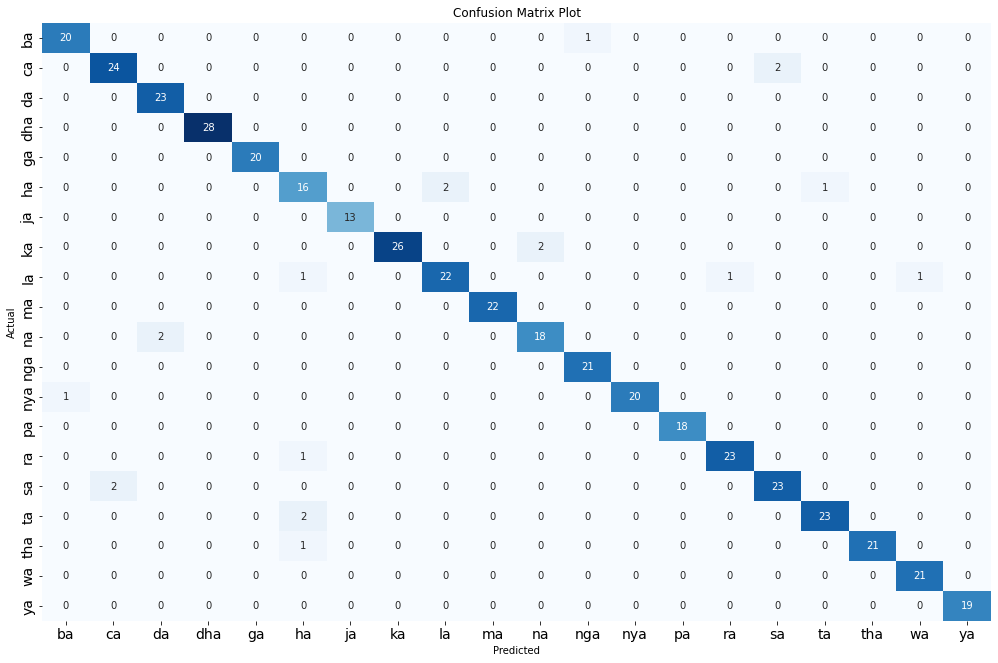

In [61]:
conf_ws = pd.DataFrame(confusion_matrix(y_test, y_pred), columns=hanacaraka, index=hanacaraka)

plt.figure(figsize=(17,11))

res = sns.heatmap(conf_ws, annot=True, fmt="g", cmap="Blues", cbar=False)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 14)
res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 14)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Plot")
plt.show()

In [62]:
class_rep_ws = classification_report(y_test, y_pred)

print("Classification report result:")
print(class_rep_ws)

Classification report result:
              precision    recall  f1-score   support

          ba       0.95      0.95      0.95        21
          ca       0.92      0.92      0.92        26
          da       0.92      1.00      0.96        23
         dha       1.00      1.00      1.00        28
          ga       1.00      1.00      1.00        20
          ha       0.76      0.84      0.80        19
          ja       1.00      1.00      1.00        13
          ka       1.00      0.93      0.96        28
          la       0.92      0.88      0.90        25
          ma       1.00      1.00      1.00        22
          na       0.90      0.90      0.90        20
         nga       0.95      1.00      0.98        21
         nya       1.00      0.95      0.98        21
          pa       1.00      1.00      1.00        18
          ra       0.96      0.96      0.96        24
          sa       0.92      0.92      0.92        25
          ta       0.96      0.92      0.94        

### Result Accuracy Score for SVM with SIFT

In [63]:
acc_ws = accuracy_score(y_test, y_pred)
print("Accuracy score:", acc_ws)

Accuracy score: 0.9546485260770975


# Note for Result SIFT With SVM

### Testing Scenario
- Img = \[ 64, 96, 128, 164, 192, 224 \]
  - Img prep = Greyscale, Equalization
- K = \[ 1000, 700, 500, 350, 240, 180 \]
- C = \[ 1, 3, 6, 10, 15\]
- G = \[ 'auto', 0.001, 0.0015, 0.0025, 0.003 \]

### Result:
- Img = (25,25), K = 180, SVM = 0.61
- Img = (28,28), K = 140, SVM = 0.59
- Img = (32,32), K = 140, SVM = 0.69
- Img = (64,64), K = 180, SVM = 0.89
- Img = (64,64), K = 240, SVM = .89:.90
- Img = (96,96), K = 240, SVM = .89:.89
- Img = (128,128), K = 140, SVM = .87:.89
- Img = (128,128), K = 180, SVM = .88:.93
- Img = (128,128), K = 240, SVM = .90:.95
- Img = (128,128), K = 350, SVM = .91:.94
- Img = (128,128), K = 500, SVM = .92:.95
- Img = (128,128), K = 700, SVM = .92:.94
- Img = (128,128), K = 1000, SVM = .92:.94
- Img = (164,164), K = 240, SVM = .90:.91
- Img = (192,192), K = 240, SVM = .90:.92
- Img = (224,224), K = 240, SVM = .88:.90


======================================

- Img = (128,128), K = 60, KNN = 0.69, SVM = 0.82
- Img = (128,128), K = 80, KNN = 0.71, SVM = 0.88
- Img = (128,128), K = 100, KNN = 0.76, SVM = 0.90
- Img = (128,128), K = 120, KNN = 0.74, SVM = 0.91
- Img = (128,128), K = 140, KNN = 0.78, SVM = 0.92
- Img = (128,128), K = 160, KNN = 0.76, SVM = 0.93
- Img = (128,128), K = 180, KNN = 0.75, SVM = 0.92
- Img = (128,128), K = 200, KNN = 0.75, SVM = 0.94 (G,T) / 0.92 (G,E) / 0.86 (G,E,T) / 0.86 (G,T,E)
- Img = (128,128), K = 240, KNN = 0.76, SVM = 0.96 (G,T) / 0.90:0.94 (G,E)
- Img = (128,128), K = 350, KNN = 0.75, SVM = 0.94
- Img = (128,128), K = 500, KNN = 0.76, SVM = 0.97
- Img = (128,128), K = 700, KNN = 0.71, SVM = 0.95
- Img = (128,128), K = 1000, KNN = 0.63, SVM = 0.95


### Conclusion
- Best image : 128x128
  1. 128: .90:.94
  2. 192: .90:.92
  3. 164: .90:.91
  4. 64: .89:.90
  5. 96: .89:.89
  6. 224: .88:.90
- Best K val : 500 
  1. 500 : .92:.95
  2. 240 : .90:.95
  3. 700 : .92:.94
  4. 1000 : .92:.94
  5. 350 : .91:.94
  6. 180 : .88:.93
- Best C val : 6
- Best G val : 0.0015

# Classification Without SIFT

- input: `X, y`
- output: -

### Image Preprocessing

Data should be resized for lower time consumtion training

In [35]:
# new_X = X
new_X = []

for i in range(X.shape[0]) :
    new_X.append(equalizing(resizing(X[i], 28)))
    
new_X = np.array(new_X, dtype=np.uint8)

### Visualize Result Data

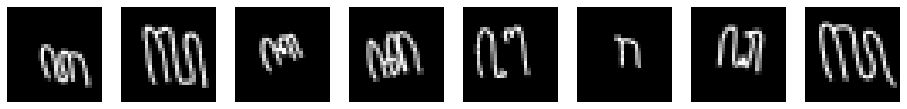

In [36]:
np.random.seed(42)

fig = plt.figure(figsize=(16, 4))
columns = 8
rows = 1
for i in range(1, columns*rows + 1):
    img = np.array(new_X[np.random.randint(0, new_X.shape[0]), :])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap='gray', vmin=0, vmax=255)
    plt.axis('off')

plt.show()

### Preprocessing

In [37]:
# reshape data
X_feature = np.reshape(new_X, (new_X.shape[0], new_X[0].shape[0]*new_X[0].shape[1]))
print("Feature X data dimension:", X_feature.shape)

Feature X data dimension: (2940, 784)


In [38]:
# normalization
scaler = StandardScaler().fit(X_feature)
X_scale = scaler.transform(X_feature)

#### Save scaler

In [39]:
# Just save normalization function for future used
save_file_pickle(SCALER_WOS_FILE_PICKLE)

In [40]:
# splitting data
X_train, X_test, y_train, y_test = train_test_split(X_scale, y, test_size=0.15, random_state=42)

print("Size of training:", X_train.shape[0])
print("Size of testing:", X_test.shape[0])

Size of training: 2499
Size of testing: 441


### SVM

Using GridSearchCV for tuning parameter, with scenario:
- 'C': \[ 1, 3, 6, 10, 15 \]
- 'gamma': \[ 'auto', 0.0008, 0.001, 0.0015, 0.0018 \]
    - 'auto' = 1 / nfeatures

#### Load model

In [41]:
# Just load model without re-training if you want
svm_wos = load_file_pickle(SVM_WOS_FILE_PICKLE)

In [42]:
svm_wos_params = {
    'C': [1, 3, 6, 10, 15],
    'gamma': ['auto', 0.0008, 0.001, 0.0015, 0.0018],
}
svm_wos = GridSearchCV(estimator=SVC(kernel='rbf', probability=True), param_grid=svm_wos_params, cv=5, verbose=3)

In [43]:
svm_wos.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ...................C=1, gamma=auto;, score=0.372 total time=   5.7s
[CV 2/5] END ...................C=1, gamma=auto;, score=0.386 total time=   4.5s
[CV 3/5] END ...................C=1, gamma=auto;, score=0.354 total time=   7.2s
[CV 4/5] END ...................C=1, gamma=auto;, score=0.368 total time=   7.6s
[CV 5/5] END ...................C=1, gamma=auto;, score=0.371 total time=   7.8s
[CV 1/5] END .................C=1, gamma=0.0008;, score=0.354 total time=   7.0s
[CV 2/5] END .................C=1, gamma=0.0008;, score=0.348 total time=   6.5s
[CV 3/5] END .................C=1, gamma=0.0008;, score=0.318 total time=   6.3s
[CV 4/5] END .................C=1, gamma=0.0008;, score=0.346 total time=   6.5s
[CV 5/5] END .................C=1, gamma=0.0008;, score=0.349 total time=   5.5s
[CV 1/5] END ..................C=1, gamma=0.001;, score=0.372 total time=   5.9s
[CV 2/5] END ..................C=1, gamma=0.001

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [1, 3, 6, 10, 15],
                         'gamma': ['auto', 0.0008, 0.001, 0.0015, 0.0018]},
             verbose=3)

In [44]:
print("Best Model:", svm_wos.best_estimator_)
print("Best CV Score:", svm_wos.best_score_)

Best Model: SVC(C=15, gamma=0.0015)
Best CV Score: 0.47459478957915835


#### All result score CV from tuning parameter SVM

In [45]:
cv_results_df = pd.DataFrame(svm_wos.cv_results_)
cv_results_df = cv_results_df.sort_values(by=['rank_test_score'])
cv_results_df = (
    cv_results_df
    .set_index(cv_results_df["params"].apply(
        lambda x: "_".join(str(val) for val in x.values()))
    )
    .rename_axis('kernel')
)
cv_results_df[
    ['params', 'rank_test_score', 'mean_test_score', 'std_test_score']
]

,params,rank_test_score,mean_test_score,std_test_score
kernel,,,,
15_0.0015,"{'C': 15, 'gamma': 0.0015}",1,0.474595,0.013932
15_auto,"{'C': 15, 'gamma': 'auto'}",2,0.472591,0.010457
6_0.0015,"{'C': 6, 'gamma': 0.0015}",3,0.472192,0.007324
10_0.001,"{'C': 10, 'gamma': 0.001}",4,0.471793,0.012712
6_auto,"{'C': 6, 'gamma': 'auto'}",5,0.470990,0.011132
6_0.001,"{'C': 6, 'gamma': 0.001}",6,0.470592,0.006964
10_0.0015,"{'C': 10, 'gamma': 0.0015}",7,0.469793,0.012805
10_auto,"{'C': 10, 'gamma': 'auto'}",8,0.469391,0.013164
6_0.0008,"{'C': 6, 'gamma': 0.0008}",9,0.466592,0.007350


#### Save model

In [46]:
# Just save model for future used
save_file_pickle(SVM_WOS_FILE_PICKLE)

### Predict Data Testing

Using SVC(C=10, gamma=0.0015)

In [47]:
y_pred = svm_wos.predict(X_test)

In [ ]:
test = svm_wos.predict_proba(np.reshape(X_test[0], (1, -1)))
test

#### Heatmap result predict

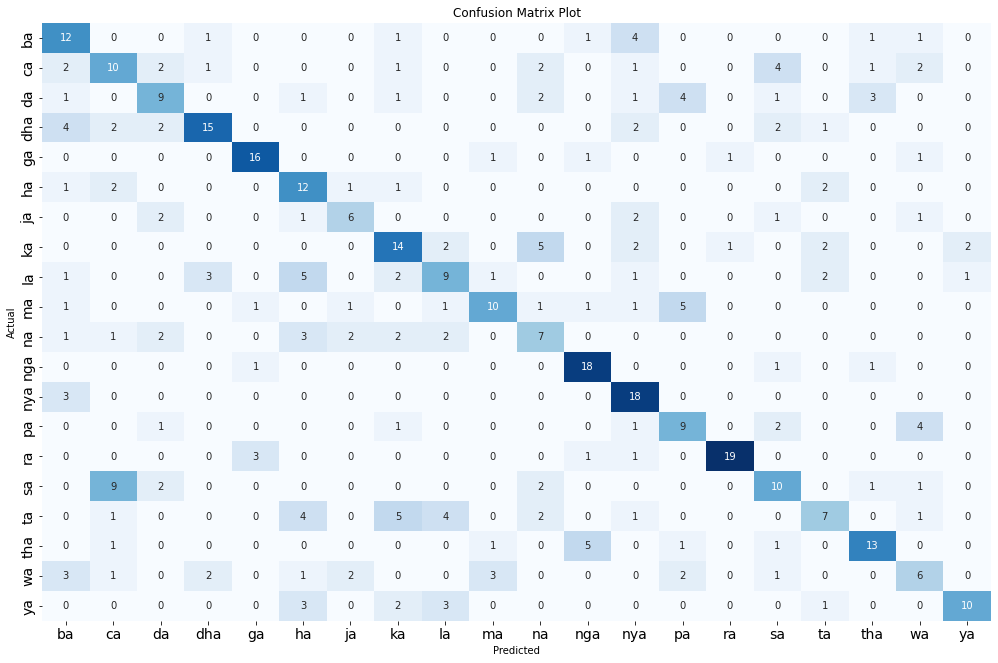

In [48]:
conf_wos = pd.DataFrame(confusion_matrix(y_test, y_pred), columns=hanacaraka, index=hanacaraka)

plt.figure(figsize=(17,11))

res = sns.heatmap(conf_wos, annot=True, fmt="g", cmap="Blues", cbar=False)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 14)
res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 14)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Plot")
plt.show()

In [49]:
class_rep_wos = classification_report(y_test, y_pred)

print("Classification report result:")
print(class_rep_wos)

Classification report result:
              precision    recall  f1-score   support

          ba       0.41      0.57      0.48        21
          ca       0.37      0.38      0.38        26
          da       0.45      0.39      0.42        23
         dha       0.68      0.54      0.60        28
          ga       0.76      0.80      0.78        20
          ha       0.40      0.63      0.49        19
          ja       0.50      0.46      0.48        13
          ka       0.47      0.50      0.48        28
          la       0.43      0.36      0.39        25
          ma       0.62      0.45      0.53        22
          na       0.33      0.35      0.34        20
         nga       0.67      0.86      0.75        21
         nya       0.51      0.86      0.64        21
          pa       0.43      0.50      0.46        18
          ra       0.90      0.79      0.84        24
          sa       0.43      0.40      0.42        25
          ta       0.47      0.28      0.35        

### Result Accuracy Score for SVM without SIFT

In [50]:
acc_wos = accuracy_score(y_test, y_pred)
print("Accuracy score:", acc_wos)

Accuracy score: 0.5215419501133787


# Note for Result SVM Without WIFT

### Result:

- Img = (25,25), SVM = 0.57
- Img = (28,28), SVM = 0.51
- Img = (32,32), SVM = 0.54
- Img = (64,64), SVM = 0.45

# SVM With SIFT vs SVM Without SIFT Comparison

In [51]:
compare_df = pd.DataFrame({"Model_SVM": ["Without SIFT", "With SIFT"],
                          "Accuracy": [acc_wos, acc_ws]})

compare_df

,Model_SVM,Accuracy
0,Without SIFT,0.521542
1,With SIFT,0.954649


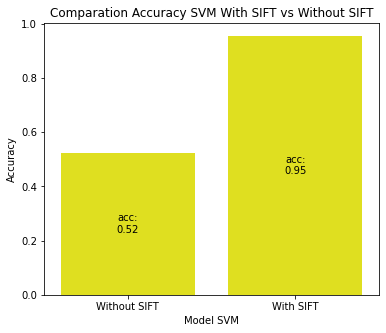

In [52]:
fig, ax = plt.subplots(figsize=(6, 5))

sns.barplot(x = 'Model_SVM',
            y = 'Accuracy',
            data = compare_df,
            ax=ax,
            color='yellow')

ax.bar_label(ax.containers[-1], fmt='acc:\n%.2f', label_type='center')
ax.set(ylabel='Accuracy', xlabel='Model SVM', title="Comparation Accuracy SVM With SIFT vs Without SIFT")

plt.show()

# Predict From Input File

In [53]:
from ipywidgets import Button
from tkinter import Tk, filedialog
from IPython.display import clear_output, display

# Load file ==================================================================================
def import_image(file) :
    image = cv2.imread(file)
    image = cv2.bitwise_not(image)
    return image
# ============================================================================================
# Preprocessing Image ========================================================================
def equalizing(img):
    img = cv2.equalizeHist(img)
    return img

def grayscaling(image):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    return image

def resizing(image, size):
    image = cv2.resize(image, (size, size), interpolation = cv2.INTER_AREA)
    return image

def prep_image(image):
    img = resizing(image, 128)
    img = grayscaling(img)
    img = equalizing(img)
    return img
# ============================================================================================
# Feature Extraction =========================================================================
def extract_sift_descriptor(image):
    sift = cv2.SIFT_create()
    _, descriptor = sift.detectAndCompute(image, None)
    return descriptor

def create_feature_bow(image_descriptor, bow, num_cluster):
    features = np.array([0] * num_cluster, dtype=float)

    if image_descriptor is not None:
        distance = cdist(image_descriptor, bow)
        argmin = np.argmin(distance, axis = 1)
        
        for j in argmin:
            features[j] += 1.0

    return np.array(features)

def extract_feature(image):
    img_descriptor = extract_sift_descriptor(image)
    
    num_cluster = 500
    bow = load_file_pickle(BOW_FILE_PICKLE)
    
    img_feature = create_feature_bow(img_descriptor, bow, num_cluster)
    return img_feature
# ============================================================================================
# Prediction Process =========================================================================
def predict_image(feature):
    scaler = load_file_pickle(SCALER_WS_FILE_PICKLE)
    feature_scale = scaler.transform([feature])
    
    svm_model = load_file_pickle(SVM_WS_FILE_PICKLE)
    result_predict = svm_model.predict(feature_scale)
    return result_predict
# ============================================================================================
# Open widget laod file ======================================================================
def select_files(b):
    clear_output()
    root = Tk()
    root.withdraw() 
    root.call('wm', 'attributes', '.', '-topmost', True)
    
    b.files = filedialog.askopenfilename(multiple=True) 
    print(b.files[0])
    processing_files(b.files[0])
# ============================================================================================
# Open widget laod file ======================================================================
def processing_files(file):
    img = import_image(file)
    plt.imshow(img, cmap='gray', vmin=0, vmax=255)
    img = prep_image(img)
    
    img_feature = extract_feature(img)
    result_predict = predict_image(img_feature)
    print("Result Class Prediction :", result_predict)
# ============================================================================================

fileselect = Button(description="File select")
fileselect.on_click(select_files)

display(fileselect)

Button(description='File select', style=ButtonStyle())